In [1]:
# Import libraries
import os
import datetime
import pathlib
import requests
import io
import shutil
from glob import glob

# from qgis.core import *
# import qmarxan_utils as qmu # import runMarxanOnce
# import marxanconpy as mx

import earthpy as et
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rasterio.crs import CRS
from rasterio.plot import plotting_extent
import rioxarray as rxr

import kba_thresh_sa_scripts as ks

# set global cache override variable
CACHE_OVERRIDE = False

#### Check for 'earth-analytics/data/kba_thresh_sa' directory
* If it exists, it will be set as the working directory.
* If it doesn't exist, user is prompted to return to first notebook in workflow.

#### *IN THE FUTURE -* 
* Should there also be a check to verify that the 'hex_shp' dir exists, and/or 
that the 'hex_shp' directory actually contains shapefiles? 

In [2]:
# Define a filepath to 'earth-analytics/data/kba_thresh_sa' directory
data_path = os.path.normpath(os.path.join(et.io.HOME, 
                                          'earth-analytics', 
                                          'data', 
                                          'kba_thresh_sa'))

# Check if 'kba_thresh_sa' directory exists.  If it doesn't, prompt user to 
# return to the first notebook to begin workflow.  If it does, change working
# directory to 'earth-analytics/data/kba_thresh_sa', and define the path to 
# hex files directory that was created in the first notebook.
if os.path.exists(data_path):
 print('Working directory is set to earth-analytics/data/kba_thresh_sa.')
 os.chdir(data_path)
 # define the path to the hexfiles that was created in the 1st notebook
 shp_data_path = os.path.normpath(os.path.join(data_path, 'hex_shp'))
else:
 print("Please go to first notebook in workflow to set up initial'\
      'directories")
 

Working directory is set to earth-analytics/data/kba_thresh_sa.


#### Save table of information to 'earth-analytics/data/kba_thresh_sa'  

* The workflow requires an associated table, with information about the 
ecosystems to be analyzed *(Need to provide more detail about what specific 
information this table requires... Or will we simply work with the full Landfire
readme info, which is saved to the repo?  If so, do we need to add a unique 
one-word 'Short_Name' to each ecosystem listed, or change the file-naming system 
to use one of the existing numerical unique identifiers - like 'OID' or 
'Value'?)*.  

* This file will be saved locally to the 'earth-analytics/data/kba_thresh_sa' 
directory.  

* In our inital workflow, we are using the 'LF_EVT_2020_README' file that was
provided along with the Landfire raster.  
&nbsp; I've manually edited this file to  
&emsp; 1. show only the rows for the nine ecosystems selected for initial 
analysis.  
&emsp; 2. add a new column to show the one word short name Lana used when creating 
her initial files in ArcGIS.  

* This file has been manually uploaded to our GitHub repo as 'Assets/Data/
from_LF_EVT_2020_README.csv'. 

* The code below will download that file from URL to a pandas dataframe, then
save that dataframe locally as a csv.  

#### *IN THE FUTURE -* 
* This existing code could be reused if the user were prompted for a url where 
they have their table stored?
* Or,  
&emsp; 1. prompt user to save their table to 'earth-analytics/data/kba_thresh_sa' 
as specifically named 'ecosystem_info.csv'  
&emsp; 2. Then check for 'ecosystem_info.csv' in 
'earth-analytics/data/kba_thresh_sa'  
&emsp; 3. If found, load to dataframe  
&emsp; &emsp; If not found, prompt user to "Save ecosystm_info.csv' to 'earth-analytics
/data/kba_thresh_sa' directory, then rerun notebook" 
        
           

In [3]:
# Download the csv file stored on GitHub repository 
# (contains info on selected ecosystems taken from LF_EVT_2020_README 
# file, with an added 'Short_Name' field that is used as index)

# Provide the URL (using raw content at GitHub)
ecoinfo_url = ("https://raw.githubusercontent.com/csandberg303/"
               "kba-threshold-sensitivity-analysis/main/assets/data/"
               "from_LF_EVT_2020_README.csv")

# Create local cache overide variable
cache_override = True or CACHE_OVERRIDE

# Provide the path to local directory
ecoinfo_path = os.path.normpath(
    os.path.join(data_path, 'from_LF_EVT_2020_README.csv'))

# Create dataframe from information at provided URL
ecoinfo_df = pd.read_csv(ecoinfo_url).set_index('Short_Name')

# Check for csv in local directory and create from df if needed
if not os.path.exists(ecoinfo_path) or cache_override:
    # Read csv at URL into pandas dataframe, using 'Short_Name' col as index
    ecoinfo_df.to_csv(ecoinfo_path)
    
ecoinfo_df

,OID,Value,Count_30m,US_hectare,US_km2,EVT_Name_1,LFRDB,elcode,element_gl,NatureServ,...,A3_FINAL,B1_FINAL,B2_FINAL,C3_FINAL,D3_FINAL,RLE_FINAL,GRANK_EQUI,RED,GREEN,BLUE
Short_Name,,,,,,,,,,,,,,,,,,,,,
prairie,132,7142,106116,9550,96,Columbia Basin Palouse Prairie,7142,CES304.792,722880,Columbia Basin Palouse Prairie,...,CR,LC,LC,EN,VU,CR,G1,204,252,105
foothill,137,7147,4546277,409165,4092,Western Great Plains Foothill and Piedmont Gra...,7147,CES303.817,722856,Western Great Plains Foothill and Piedmont Gra...,...,VU,LC,LC,NT,LC,VU,G3,218,238,243
mesic,224,7322,1090956,98186,982,Crowley's Ridge Mesic Loess Slope Forest,7322,CES203.079,798100,Crowley's Ridge Mesic Loess Slope Forest,...,LC,EN,EN,VU,CR,CR (EN-CR),G1G2,144,201,143
bluff,229,7327,2050154,184514,1845,East Gulf Coastal Plain Northern Loess Bluff F...,7327,CES203.481,723105,East Gulf Coastal Plain Northern Loess Bluff F...,...,EN,LC,LC,VU-EN,EN,EN,G2,149,143,26
pine,244,7346,5015841,451426,4514,Atlantic Coastal Plain Fall-line Sandhills Lon...,7346,CES203.254,723231,Atlantic Coastal Plain Fall-line Sandhills Lon...,...,EN,LC,LC,VU,CR,EN (EN-CR),G1G2,70,96,32
tallgrass,314,7421,10225903,920331,9203,Central Tallgrass Prairie,7421,CES205.683,722976,Central Tallgrass Prairie,...,CR,LC,LC,DD,CR,CR,G1,243,201,28
dune,323,7431,19717,1775,18,Southwest Florida Dune and Coastal Grassland,7431,CES203.539,723063,Southwest Florida Dune and Coastal Grassland,...,DD,LC,LC,NE,CR,CR,G1,245,252,179
dome,335,7447,900234,81021,810,South Florida Cypress Dome,7447,CES411.365,723151,South Florida Cypress Dome,...,DD,VU,LC,DD,LC,VU,G3,54,163,120
marsh,676,9197,1634510,147106,1471,Northern Atlantic Coastal Plain Tidal Salt Marsh,9197,CES203.519,723073,Northern Atlantic Coastal Plain Tidal Salt Marsh,...,EN,LC,LC,DD,EN,EN,G2,131,173,223


In [4]:
# Add 2 columns to 'ecoinfo_df'

# 1st column - Add column 'Type' (needed for CLUZ addin input file 
#'targets.csv'; might not be needed for marxanconpy) Uses np.select to assign 
# a number (1 or 2), based upon the string seen in the 'RLE_FINAL' column
# (Type = 1 if 'CR', 'CR (CR-EN)', 'EN (CR-EN) or 'EN'; Type = 2 if 'VU')

# create a list of conditions
type_conditions = [(ecoinfo_df['RLE_FINAL'] == 'CR'), 
                  (ecoinfo_df['RLE_FINAL'] == 'CR (EN-CR)'),
                  (ecoinfo_df['RLE_FINAL'] == 'EN'),
                  (ecoinfo_df['RLE_FINAL'] == 'EN (EN-CR)'),
                  (ecoinfo_df['RLE_FINAL'] == 'VU')]

# create a list of the values to assign for each condition
type_values = [1, 1, 1, 1, 2]

# create new column using np.select to assign values using lists as arguments
ecoinfo_df['Type'] = np.select(type_conditions, type_values)

# 2nd column - Add column 'Current_IUCN_TH'. Uses np.select to assign a 
# threshold percentage, based upon the column 'Type' (5% if 1, 10% if 2)

# create a list of conditions
current_threshold_conditions = [(ecoinfo_df['Type'] == 1), 
                               (ecoinfo_df['Type'] == 2)]

# create a list of the values to assign for each condition
current_threshold_values = [.05, .10]

# create new column using np.select to assign values using lists as arguments
ecoinfo_df['Current_IUCN_TH'] = np.select(
    current_threshold_conditions, current_threshold_values)

ecoinfo_df

,OID,Value,Count_30m,US_hectare,US_km2,EVT_Name_1,LFRDB,elcode,element_gl,NatureServ,...,B2_FINAL,C3_FINAL,D3_FINAL,RLE_FINAL,GRANK_EQUI,RED,GREEN,BLUE,Type,Current_IUCN_TH
Short_Name,,,,,,,,,,,,,,,,,,,,,
prairie,132,7142,106116,9550,96,Columbia Basin Palouse Prairie,7142,CES304.792,722880,Columbia Basin Palouse Prairie,...,LC,EN,VU,CR,G1,204,252,105,1,0.05
foothill,137,7147,4546277,409165,4092,Western Great Plains Foothill and Piedmont Gra...,7147,CES303.817,722856,Western Great Plains Foothill and Piedmont Gra...,...,LC,NT,LC,VU,G3,218,238,243,2,0.10
mesic,224,7322,1090956,98186,982,Crowley's Ridge Mesic Loess Slope Forest,7322,CES203.079,798100,Crowley's Ridge Mesic Loess Slope Forest,...,EN,VU,CR,CR (EN-CR),G1G2,144,201,143,1,0.05
bluff,229,7327,2050154,184514,1845,East Gulf Coastal Plain Northern Loess Bluff F...,7327,CES203.481,723105,East Gulf Coastal Plain Northern Loess Bluff F...,...,LC,VU-EN,EN,EN,G2,149,143,26,1,0.05
pine,244,7346,5015841,451426,4514,Atlantic Coastal Plain Fall-line Sandhills Lon...,7346,CES203.254,723231,Atlantic Coastal Plain Fall-line Sandhills Lon...,...,LC,VU,CR,EN (EN-CR),G1G2,70,96,32,1,0.05
tallgrass,314,7421,10225903,920331,9203,Central Tallgrass Prairie,7421,CES205.683,722976,Central Tallgrass Prairie,...,LC,DD,CR,CR,G1,243,201,28,1,0.05
dune,323,7431,19717,1775,18,Southwest Florida Dune and Coastal Grassland,7431,CES203.539,723063,Southwest Florida Dune and Coastal Grassland,...,LC,NE,CR,CR,G1,245,252,179,1,0.05
dome,335,7447,900234,81021,810,South Florida Cypress Dome,7447,CES411.365,723151,South Florida Cypress Dome,...,LC,DD,LC,VU,G3,54,163,120,2,0.10
marsh,676,9197,1634510,147106,1471,Northern Atlantic Coastal Plain Tidal Salt Marsh,9197,CES203.519,723073,Northern Atlantic Coastal Plain Tidal Salt Marsh,...,LC,DD,EN,EN,G2,131,173,223,1,0.05


#### *IN THE FUTURE -* 

Currently our code will work with the ecosystem raster and hex files that Lana 
created in ArcGIS using the ArcMarxan plugin.  Ultimately we hope to work directly
with the full Landfire EVT 2020 raster, but the file is proving too large to 
effectively manage with our personal laptops. A solution may be found using the 
2016 Landfire data which has an available API (the 2020 data is scheduled to be 
published to the API later this year). An alternitive solution may be found using 
Dask.

If/When our code can access the full CONUS raster, the source data in repo assets 
(and links that file in this code) will need to be updated to the full version of 
the raster's LF_2020_EVT_README file. Once that occurs, we could ask for user 
input to get entries matching the 'Values' column in that file, as a way of 
selecting specific ecosystems from the full Landfire EVT 2020 data. That user 
input would be assigned to a list variable 'value_filter'. 

The user would then be prompted for a one-word 'Short_Name' value for each 
ecosystem being analyzed (ex. mesic, dune, dome), to be used in file naming. This 
abbreviated name would be added to the ecoinfo_df.  

Currently the 'Short_Name' values have been hardcoded, to match what Lana chose 
when creating her ArcGis files. The 'value_filter' variable will also be 
hardcoded, to match the values seen in the LF_2020_EVT_README file for the three 
ecosystems we are using as test data (Crowley's Ridge Mesic Loess Slope Forest, 
Southwest Florida Dune and Coastal Grassland, and South Florida Cypress Dome).


In [5]:
# Create lists that will be used later in iteration loops

# Create list of threshold values to test
test_threshold = [1.0, 0.75, 0.50, 0.25]

# Define list variable 'value_filter' to show the values matching the 'Values' 
# column of ecoinfo_df for the three ecosystems which have shp and hex files 
# uploaded to the GitHub repository - 'dome', 'dune', and 'mesic', 
value_filter = [7431, 7322, 7447]

# use value_filter to create a new df with only matching records
eco_subset_df = ecoinfo_df[ecoinfo_df['Value'].isin(value_filter)]

# Create alphabetical list of ecosystems to be analyzed, taken from the 
# 'Short_Name' column of eco_subset_df
eco_list = eco_subset_df.index.values.tolist()
eco_list.sort()
# print(eco_list)
eco_list


['dome', 'dune', 'mesic']

In [6]:
# Define path to Marxan.exe executable file has been manually copied over to 
# 'kba_thresh_sa' directory (maybe it can be copied to there from repo?

marxan_path = os.path.join(data_path, "Marxan_x64.exe")


In [7]:
# Define variables to be used in Marxan analysis

# ESPG value to set as CRS for raster and shapefile
espg = '5070'

# 'proportion', as used in input.dat and spec.dat 
# (must be between 0 and 1, Lana tutorial suggested 0.3)
prop=0.3

# Scenario ID - used as a prefix in the output files Marxan creates
# (this should be some abbrev concatenation of KBA threshold test and eco, to 
#be created later on within the loop?)
scen_id = "eco_xyz"

# Species Penalty Factor - more detail needed... we're using default val of 1
spf = 1

# set minclump value - seen in spec.dat default val = False
minclump = False


#### Loop through the eco_list, create directories and input files needed by Marxan.

Each time the code below runs, a new timestamped diretory is created. Inside will
be subdirectories created from the 'Short_Name' value of the selected ecosystems 
seen in the 'eco_subset' variable.

Each of these ecosystem subdirectories will have the following named 
subdirectories -
* input - where files needed by marxan analysis are stored (bound.dat, pu.dat, 
puvsp.dat, spec.dat)
* output - where files generated by marxan analysis are stored
* pu - pu and report seen in qmarxan setup (purpose tbd)
* report - pu and report seen in qmarxan setup (purpose tbd)
* source data - where the rasters and PU hex_shp files are moved to, after they
are copied from the 'r_tif' and 'hex_shp' folders

A fifth input file 'input.dat' is created and placed in the main ecosystem 
directory.

The code below will also create a 'targets.csv' file for each value in 
the 'test_threshold' list variable.  This is done using the function 
'create_targets_files'. These 'targets.csv' files are used by the CLUZ 
plugin in QGIS.  They are not used by the QMarxan QGIS plugin, and ultimately may
not be needed for our marxanconpy workflow.  *Perhaps the loop inside
the function that uses the 'test_threshold' variable could be reused for another 
purpose?*

Currently, we are using the input files that Lana created using ArcGIS, that have 
been saved to the repo.  The code below will simply copy those files from the repo 
and save them into each ecosystem's 'input' folder.

#### *IN THE FUTURE -* 
* Our project sponsor has said that the set of input files are commonly prepared 
using GIS tools.  If that is the practice we will continue, new files for 
additional ecosystmes will be generated using QGIS/QMarxan.
* Another option may be to create a new function in this workflow for each 
specific input file (input.dat, bound.dat, pu.dat, puvsp.dat, spec.dat.).  A 
function has been written to create the input.dat file, using code seen in the 
qmarxan repository from Apropos Information Systems (used under the GPL-2.0 
license). Creating the input files programatically rather than in GIS may allow 
for easier manipulation of the files within the workflow to perform the 
sensitivity analysis of the KBA threshold values.

In [8]:
# STEP 1:
# Create a timestamped directory, with a subdirectory for each ecosystem 
# selected in 'value_filter'.  Each ecosystem directory includes the four 
# directories that are created when the qmarxan toolbox is used in QGIS 
# ('input', 'output', 'report', 'pu').  Four .dat files are saved to the input
# folder which are either created directly with formulas (pu.dat and spec.dat)
# or copied from the repo where Lana's ArcGIS files have been stored 
# (bound.dat and puvsp.dat). A fifth .dat file 'input.dat' is created by 
# formula and saved to the outer ecosystm directory.

# A 'source_data' directory is also created, where the ecosystem's .shp and 
# .tif files are copied from the main 'kba_thresh_sa/hex_shp' and 
# 'kba_thresh_sa/r_tif' directories. A function will reproject these files to 
# ESPG: 5070.

# An additional function has been written to create the 'targets.csv' files 
# for each value in the 'test_threshold' list variable; these files are used 
# by the CLUZ plug-in in QGIS but may not ultimately be needed by 
# Marxan/marxanconpy)

newdir = os.path.normpath(os.path.join(data_path, 
                                       datetime.datetime.now().strftime(
                                           '%Y%m%d_%H%M%S')))
os.makedirs(newdir)
os.chdir(newdir)
for eco in eco_list:
    os.makedirs(eco),
    eco_data_path = os.path.normpath(os.path.join(data_path, newdir, eco))
    os.chdir(eco_data_path)
    os.makedirs('source_data')
    os.chdir('source_data')
    ks.get_source_files(os.path.join(data_path, "hex_shp"), eco)
    ks.get_source_files(os.path.join(data_path, "r_tif"), eco)
    ks.set_source_files_crs (data_path, eco, espg=espg)
    os.chdir(eco_data_path)
    # create 'input.dat' from formula adapted from 'qmarxan_toolbox' code; 
    # currently using default provided values, but more variables can be
    # added to function and used as needed.
    ks.create_input_dat(eco_data_path, prop=prop, scen_id = scen_id) 
    os.makedirs('input')
    eco_input_data_path = os.path.normpath(os.path.join(
        eco_data_path, 'input'))
    os.chdir(eco_input_data_path)
    # create pu.dat from original formula
    ks.create_pu_dat(eco, os.path.join(eco_data_path, 'source_data'))  
    # create spec.dat from original formula
    ks.create_spec_dat(eco_subset_df, eco, prop=prop, spf=spf, minclump=minclump)
    
    # use 'get_marxan_input_files' function to copy in Lana's ArcGIS/ArcMarxan
    # input files, for any files still needed until formulas are written to 
    # create these files directly.  Her files have been saved to the 
    # 'assets/data/marxan_input' directory of the repo.
    ks.get_marxan_input_files(eco, ["bound.dat", 
#                                     "pu.dat", 
                                    "puvsp.dat", 
#                                     "spec.dat"
                                   ])
    os.chdir(eco_data_path)

#     # A formula has been written to write CLUZ targets files for each 
#     # threshold testing value.  These CLUZ files aren't currently needed, 
#     # but the iterative formula might be repurposed? 
#     ks.create_cluz_targets_files(eco, test_threshold, ecoinfo_df, 
#                                 eco_data_path)
    os.makedirs('output')
    os.makedirs('report')
    os.makedirs('pu')
    # call on marxan executable to run analysis
    os.startfile(marxan_path)
    print (eco + ": MARXAN ANALYSIS COMPLETED")
    # create plot of best run solution (THIS PLOT ISNT WORKING YET)
#     os.chdir('output')
#     ks.create_solution_plot(eco, eco_data_path, espg, scen_id)
    os.chdir(newdir)
    
os.getcwd()

dome: dome.cpg copied successfully
dome: dome.dbf copied successfully
dome: dome.prj copied successfully
dome: dome.sbn copied successfully
dome: dome.sbx copied successfully
dome: dome.shp copied successfully
dome: dome.shx copied successfully
dome: dome_hex.shp.xml copied successfully
dome: finished copying source files
dome: dome.tfw copied successfully
dome: dome.tif copied successfully
dome: dome.tif.aux.xml copied successfully
dome: dome.tif.ovr copied successfully
dome: dome.tif.vat.cpg copied successfully
dome: dome.tif.vat.dbf copied successfully
dome: dome.tif.xml copied successfully
dome: finished copying source files
dome: finished set_source_files_crs
dome: input.dat created successfully
dome: pu.dat file successfully created
dome: spec.dat file successfully created
dome: bound.dat successfully copied from url
dome: puvsp.dat successfully copied from url
dome: MARXAN ANALYSIS COMPLETED
dune: dune.cpg copied successfully
dune: dune.dbf copied successfully
dune: dune.prj cop

'C:\\Users\\cwsnd\\earth-analytics\\data\\kba_thresh_sa\\20220605_235243'

KeyError: 'Unit_ID'

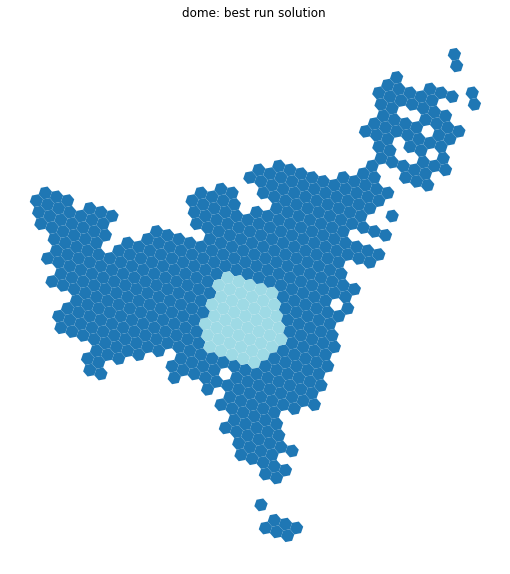

In [9]:
for eco in eco_list:
    eco_data_path = os.path.normpath(os.path.join(data_path, newdir, eco))
    os.chdir(eco_data_path)
    os.chdir('output')
    ks.create_solution_plot(eco, eco_data_path, espg, scen_id)
    os.chdir(newdir)

In [10]:
# create function to create image of best run (like dome example in qgis)

# # Open raster data
# raster_path = os.path.join(eco_data_path, 
#                            "source_data", 
#                            eco + "_espg_" + espg + ".tif")
# raster_layer = rxr.open_rasterio(raster_path, masked=True).squeeze()
# raster_extent = plotting_extent(raster_layer, raster_layer.rio.transform())

# open shapefile created in the 'set_source_files_crs' function

shp_path = os.path.join(eco_data_path, 
                        "source_data", 
                        eco + "_espg_" + espg + ".shp")         
shp_layer = gpd.read_file(shp_path)

# open 'best_run' file created by Marxan saved to 'output' directory
best_run_path = os.path.join(eco_data_path, 'output', scen_id + '_best.csv') 
best_run = pd.read_csv(best_run_path)

# merge best_run df to shp layer
best_run = best_run.rename(columns={'PUID': 'Unit_ID'})
shp_layer = shp_layer.merge(best_run, on='Unit_ID')
                              

# create visualization showing hexcell selection from best run solution
fig, ax = plt.subplots(figsize=(10, 10))
shp_layer.plot(column='SOLUTION', cmap='tab20', ax=ax)
# ax.imshow(raster_layer, cmap='BuGn', extent=raster_extent)
# ax.imshow(raster_layer)
# ax.imshow(raster_layer, cmap='BuGn')
# raster_layer.plot.imshow(cmap='BuGn')

ax.set(title= eco + ': best run solution ')

ax.set_axis_off()
# plt.savefig('solution_plot.pdf')  


KeyError: 'Unit_ID'

In [11]:
# Set plotting extent
raster_extent = plotting_extent(raster_layer, raster_layer.rio.transform())
raster_extent

# Visualize overlay of individual ecosystem raster and planning units
fig, ax = plt.subplots(figsize=(22, 14))
ax.set_title(eco + ': best run solution ', fontsize=20)
ax.imshow(raster_layer, extent=raster_extent, cmap='BuGn')
# prarie_v.plot(ax=ax, color='none', edgecolor='cyan')
ax.axis('off')
plt.show()


NameError: name 'raster_layer' is not defined

### Still To Do:

* determine when in loop to run marxan (and how? what code)

* output image of best run (like dome example in qgis)

* find total of best run, where cells were marked with '1' 
  ('Statistics by Category' in qgis ?)

* determine how to set up loop to run sensitivity analysis 
 (using which input variable(s)?)

In [ ]:
# exeFile = os.path.join(data_path, "Marxan_x64.exe")

# workingDir = eco_data_path

# outDir = os.path.join(eco_data_path, 'output')
# print (outDir)
# scenName = "eco_xyz1"
# numReps = 100
# # feedback = True

# qmu.runMarxanOnce(exeFile,workingDir,outDir,scenName,numReps, feedback)


In [ ]:
# test marxanconpy - just to see if the package is installed without error
# test_mx_proj = mx.marcon.new_project(rootpath=newdir)
# print(test_mx_proj)

# not really sure what this function's supposed to do
# test_valid = mx.marcon.validate_project(test_mx_proj)
# print(test_valid)



In [ ]:
# mx_cm = mx.manipulation.calc_metrics(test_mx_proj,progressbar=False,calc_metrics_pu=True,calc_metrics_cu=False)
# # mx_cm.info()

#### FURTHER STEPS:
Once directories & input files are set-up as needed for Marxan analysis -
the next section of needed code are functions using actual marxanconpy, and
the handling of the results 
(store files, add collected info (and summary info?) to dataframe, which 
will ultimately be saved as .csv output file)

#### THIS CELL SHOWS ORIGINAL WORKFLOW IDEA FOR REFERENCE -

GET LIST OF ECOSYSTEMS TO ANALYZE 
    (FROM PROVIDED 'LF_EVT_2020' FILE)
    
SET UP FOLDER STRUCTURE FOR EACH ECOSYSTEM (CREATE INPUT/OUTPUT FOLDERS ETC)
    (I'VE GOT SOME INITIAL CODE FOR THIS IN A JUPYTER NOTEBOOK ON OUR 
    NATURESERVE REPOSITORY)
     
GET TWO INITIAL SHAPEFILES FOR EACH ECOSYSTEM THAT WILL BE NEEDED FOR MARXAN 
ANALYSIS, SAVE TO APPROPRIATE FOLDER 
    (USE LANA'S EXISTING FILES FROM ARCGIS WITH PAT'S 2020 DATA, OR 
    INVESTIGATE LANDFIRE API FOR 2016 DATA)
     
SET UP LOGIC OF CURRENT KBA THRESHOLDS
    (FOR IUCN A2:THREATENED ECOSYSTEM TYPE
         IF ECOSYSTEM'S 'LF_EVT_2020[RLE_FINAL]' VALUE = CR, CR (EN-CR), 
                 EN or EN (EN-CR)
             THRESHOLD = >= 5% OF ECOSYSTEM TOTAL EXTENT 
                (USE 30M, US-hectare, or US_km2 COLUMN OF 'LF_EVT_2020')
         IF ECOSYSTEM'S 'LF_EVT_2020[RLE_FINAL]' VALUE = VU
             THRESHOLD = >= 10% OF ECOSYSTEM TOTAL EXTENT

CREATE LIST FOR THRESHOLD TEST (1.0, 0.75, 0.50, 0.25)
     
*INITIAL OUTPUT* - create table of 4 threshold values for each ecosystem    
     (from Pat's Study Plan - "This will result in a tabular summary of 4 
         threshold values per ecosystem type, depending on its RLE status")
     
ASSIGN EACH ECOSYSTEM TO A SPATIAL CHARACTERISTIC TYPE (PATCHY, LINEAR or 
    MATRIX) - THIS IS BASED UPON OUR VISUAL ASSESSMENT, WHICH WILL BE 
    APPROVED BY PAT)
     
ITERATION LOOP:
    FOR EACH ECOSYSTEM IN LIST
         RUN MARXANCONPY ANALYSIS (***see note below) FOR THE APPROPRIATE 
            KBA THRESHOLD, BASED ON 'RLE_FINAL'
         COMPLETE SEPARATE RUNS FOR EACH TEST LEVEL (1.0, 0.75, 0.50, 0.25)
         SAVE RESULTS FROM EACH RUN TO DATAFRAME
    SAVE DATAFRAME TO TABLE (INCL. THE ASSIGNED SPATIAL CHARACTERISTIC INFO)

SAVE FINAL DATAFRAME AS CSV
     
     
*** USING MARXANCONPY FOR FURTHER ANALYSIS
     
     INFO FROM MARXANCONPY DOCUMENTATION - 
        https://remi-daigle.github.io/marxanconpy/
        The first step is to import the package and create a MarCon dictionary.
             import marxanconpy
             import os
             project = marxanconpy.marcon.new_project()
     
     INFO FROM https://marxanconnect.ca/tutorial.html#4_marxanconpy_Python_Module
         Using the spatial dependencies approach using landscape-based data
         https://marxanconnect.ca/targets.html
     


     
